In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

In [2]:
from scipy.signal import savgol_filter
from scipy.constants import constants

In [3]:
def trigger(signals,final):
    '''First derivative triger on minimum'''
    for data in signals:  
        win = 100  # Size of the moving average window
        cumsum = np.cumsum(data)
        moving_avg = np.array((cumsum[win:] - cumsum[:-win]) / win)
        moving_avg = np.pad(moving_avg, (win - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))
        polyorder = 5
        sav_size = 100
        sg_filtered_signal = savgol_filter(moving_avg, sav_size, polyorder)
        st = savgol_filter(sg_filtered_signal,100,5,1)
        ymin = min(st)
        if ymin<-1*1e-6:
            final.append(data)
    return final


In [90]:
import os
path = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\DATA\data1EZwnzFDOlW20t1Ufkj66OG_oNNCVGLGK.hdf5'
noises, signals = [], []
with h5py.File(path,'r') as file:
    for key in file.keys():
        if 'Noise' in key:
            noises.append(np.array(file[key][:]))
        elif 'Raw' in key:
            signals.append(np.array(file[key][:])[:20000])

In [91]:
final = []
final = signals

In [92]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.
signal_matrix = np.array(final)
noise_matrix = np.array(noises[:len(signal_matrix)])

In [93]:
bsl = np.mean(signal_matrix[:,0:preStop],axis=1)
bsl_noise = np.mean(noise_matrix,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

signal_matrix = -1*(signal_matrix - np.array([bsl]).T)
noise_matrix = noise_matrix - np.array([bsl_noise]).T

In [94]:
H = []

data = np.genfromtxt('Filter.txt')
for i in range(len(data)):
    H.append(complex(data[i][0],data[i][1]))

In [95]:
H = np.array(H)

In [96]:
def parabolic_fit(mat,stop=0):

    max_pos = np.argmax(mat[:,stop:-1],axis=1) + stop
    dim     = np.arange(0,mat.shape[0])
    x1 = max_pos-1
    x2 = max_pos
    x3 = max_pos+1
    y1 = mat[dim,x1]
    y2 = mat[dim,x2]
    y3 = mat[dim,x3]
    a  = (x1*(y3-y2) + x2*(y1-y3)+x3*(y2-y1) )  / ( (x1-x2)*(x1-x3)*(x2-x3)   )
    b  = (y2-y1)/(x2-x1)-a*(x1+x2)
    c  = y1 -a*x1**2 -b*x1

    return a,b,c,max_pos

def applyOF(esignal_matrix,H):
    
    events_OF_f = np.fft.fft(esignal_matrix, axis=1)*H
    OFF         = np.array(np.sum(np.abs(events_OF_f), axis=1)/esignal_matrix.shape[1]) 
    events_OF   = np.fft.ifft(events_OF_f).real
    events_OF   = np.concatenate((events_OF[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], events_OF[:,0:int(esignal_matrix.shape[1]/2)]),axis=1)
    a,b,c       = parabolic_fit(events_OF)[0:3]
    OFmax_pos   = np.argmax(events_OF,axis=1)
    OFdelay     = -b/(2.*a)  -esignal_matrix.shape[1]/2
    OFT         = -1.*(b**2)/(4.*a) +c
    del a,b,c, events_OF_f

    OFtest = 1. - OFT/OFF

    return OFT, OFF, OFdelay, OFtest

In [97]:
print(H.shape)

(20000,)


In [98]:
maxs = [max(signal) for signal in signal_matrix]

In [99]:
print(np.mean(maxs))
print(np.std(maxs))

0.0018919513163977448
0.0003652690257306736


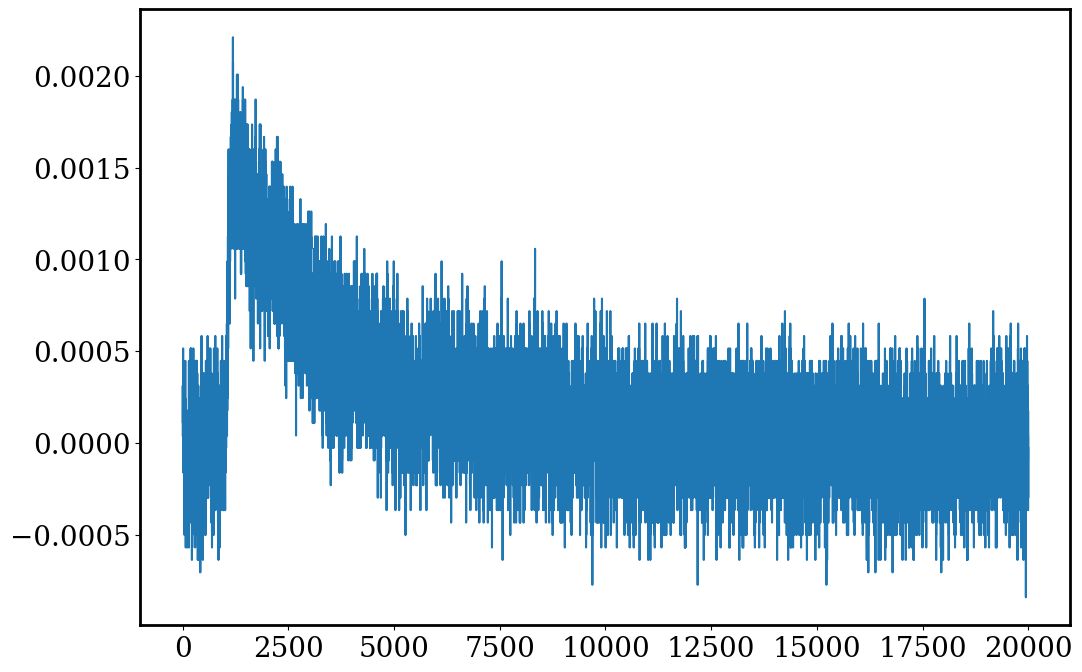

In [79]:
plt.plot(signal_matrix[1])